# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns

# "Global" Variables

In [273]:
sample_rate = 4 # Quarterly
region = 'England'

bev_lifetime = 12 # Years
phev_lifetime = 15 # Years

horizon = 2050 # How far into the future we're looking

ice_ban = 2030 # The year in which the sale of new ICE vehicles is banned in the UK
phev_ban = 2035 # The year in which the sale of new Hybrid vehicles is banned in the UK

# Convenience Functions

In [3]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

# Returns the first (and oldest) date (assuming date is the index) of a series or DataFrame
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    return t0

# Returns the last (and most recent) date (assuming date is the index) of a series or DataFrame
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75    
    return t_present

# Returns an array of numeric dates between t0 and t1 at a specified sample rate
def calculate_date_range(t0, t1, sample_rate):
    return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)

# Takes in text based dates (e.g. 2022 Q4) and returns an array of decimalised dates
def convert_dates_to_numeric(data):
    dates = np.zeros(len(data))
    for i in np.arange(len(data)):
        year = int(data.index[i][:4])
        quarter = data.index[i][-2:]
        if quarter == 'Q1':
            d = year + 0
        elif quarter == 'Q2':
            d = year + 0.25
        elif quarter == 'Q3':
            d = year + 0.5
        elif quarter == 'Q4':
            d = year + 0.75
        dates[i] = d
    return dates

# Read in Data

### VEH1153: Vehicles registered for the first time by body type and fuel type

In [4]:
drop_cols_veh1153 = [
    'Units',
]

veh1153 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1153.ods", 
        engine="odf", 
        sheet_name='VEH1153a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Date Interval [note 4]': 'Date Interval',
            'Date [note 4]': 'Date',
            'Other vehicles [note 3]': 'Other vehicles',
            'Gas [note 5]': 'Gas',
            'Other fuel types [note 6]': 'Other fuel types',
            'Plug-in [note 7]': 'Plug-in',
            'Zero emission [note 8]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1153, axis=1)
)

# Convert units from Thousands to real counts
veh1153.iloc[:, 4:] = veh1153.iloc[:, 4:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1153['ICE'] = veh1153['Total'] - veh1153['Plug-in'] - veh1153['Fuel cell electric']

# Remove bracketed text from Dates
veh1153['Date'] = veh1153['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1153.head()

Geography Date Interval  Date BodyType     Petrol    Diesel  \
374   England        Annual  2001     Cars  1874649.0  405214.0   
375   England        Annual  2002     Cars  1793879.0  563102.0   
376   England        Annual  2003     Cars  1679322.0  641920.0   
377   England        Annual  2004     Cars  1524998.0  749242.0   
378   England        Annual  2005     Cars  1343752.0  794699.0   

     Hybrid electric (petrol)  Hybrid electric (diesel)  \
374                     604.0                       3.0   
375                     270.0                       0.0   
376                     351.0                       0.0   
377                    1442.0                       0.0   
378                    4997.0                       3.0   

     Plug-in hybrid electric (petrol)  Plug-in hybrid electric (diesel)  \
374                               0.0                               0.0   
375                               0.0                               0.0   
376                               0.0                               0.0   
377                               0.0                               0.0   
378                               0.0                               0.0   

     Battery electric  Range extended electric  Fuel cell electric     Gas  \
374              81.0                      0.0                 0.0  1954.0   
375              58.0                      0.0                 1.0  2311.0   
376              39.0                      0.0                 3.0  3086.0   
377              90.0                      0.0                 2.0  1681.0   
378             223.0                      0.0                 4.0   482.0   

     Other fuel types      Total  Plug-in  Zero emission        ICE  
374               7.0  2282512.0     81.0           81.0  2282431.0  
375               3.0  2359624.0     58.0           59.0  2359565.0  
376               6.0  2324727.0     39.0           42.0  2324685.0  
377               8.0  2277463.0     90.0           92.0  2277371.0  
378              13.0  2144173.0    223.0          227.0  2143946.0

### VEH1103: Licensed vehicles at the end of the quarter by body type and fuel type

In [5]:
drop_cols_veh1103 = [
    'Units',
]

veh1103 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1103.ods", 
        engine="odf", 
        sheet_name='VEH1103a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Gas [note 4]': 'Gas',
            'Other fuel types [note 5]': 'Other fuel types',
            'Plug-in [note 6]': 'Plug-in',
            'Zero emission [note 7]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1103, axis=1)
)

# Convert units from Thousands to real counts
veh1103.iloc[:, 3:] = veh1103.iloc[:, 3:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1103['ICE'] = veh1103['Total'] - veh1103['Plug-in'] - veh1103['Fuel cell electric']

# Remove bracketed text from Dates
veh1103['Date'] = veh1103['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1103.head()

Geography     Date BodyType      Petrol     Diesel  \
72   England  1994 Q4     Cars  16694257.0  1313637.0   
73   England  1995 Q4     Cars  16635739.0  1573698.0   
74   England  1996 Q4     Cars  17149424.0  1811387.0   
75   England  1997 Q4     Cars  17505628.0  2031080.0   
76   England  1998 Q4     Cars  17744318.0  2247998.0   

    Hybrid electric (petrol)  Hybrid electric (diesel)  \
72                       0.0                       0.0   
73                       0.0                       0.0   
74                       0.0                       0.0   
75                       0.0                       0.0   
76                       0.0                       0.0   

    Plug-in hybrid electric (petrol)  Plug-in hybrid electric (diesel)  \
72                               0.0                               0.0   
73                               0.0                               0.0   
74                               0.0                               0.0   
75                               0.0                               0.0   
76                               0.0                               0.0   

    Battery electric  Range extended electric  Fuel cell electric     Gas  \
72              81.0                      0.0                 0.0  1543.0   
73              61.0                      0.0                 0.0  2518.0   
74              79.0                      0.0                 0.0  3587.0   
75             101.0                      0.0                 0.0  5577.0   
76             140.0                      0.0                 0.0  8650.0   

    Other fuel types       Total  Plug-in  Zero emission         ICE  
72             192.0  18009710.0     81.0           81.0  18009629.0  
73             121.0  18212137.0     61.0           61.0  18212076.0  
74             107.0  18964584.0     79.0           79.0  18964505.0  
75             104.0  19542490.0    101.0          101.0  19542389.0  
76             100.0  20001206.0    140.0          140.0  20001066.0

### LSOA Lookup Data

In [6]:
LAD = 'Bath and North East Somerset' # Target Local Authority District

In [7]:
lsoa_lookup = pd.read_csv('../../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

LSOA11CD                   LSOA11NM   LSOA21CD                   LSOA21NM  \
0  E01000001        City of London 001A  E01000001        City of London 001A   
1  E01000002        City of London 001B  E01000002        City of London 001B   
2  E01000003        City of London 001C  E01000003        City of London 001C   
3  E01000005        City of London 001E  E01000005        City of London 001E   
4  E01000006  Barking and Dagenham 016A  E01000006  Barking and Dagenham 016A   

  CHGIND    LAD22CD               LAD22NM LAD22NMW  ObjectId  
0      U  E09000001        City of London      NaN         1  
1      U  E09000001        City of London      NaN         2  
2      U  E09000001        City of London      NaN         3  
3      U  E09000001        City of London      NaN         4  
4      U  E09000002  Barking and Dagenham      NaN         5

### Historical Total Vehicle Registration Data for LSOAs

In [8]:
v_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Cars' and Keepership == 'Private' and LicenceStatus == 'Licensed'")
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority (BNES)
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
v_lsoa = v_lsoa[~v_lsoa.index.duplicated(keep='first')]

v_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370    361.0    353.0    357.0    352.0    369.0    390.0    382.0   
E01014371    502.0    512.0    507.0    524.0    517.0    524.0    524.0   
E01014372    495.0    507.0    506.0    509.0    513.0    508.0    506.0   
E01014373    753.0    754.0    770.0    768.0    775.0    762.0    773.0   
E01014374    752.0    762.0    759.0    756.0    746.0    750.0    741.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2012 Q1  2011 Q4  2011 Q3  2011 Q2  \
LSOA11CD                              ...                                       
E01014370    380.0    371.0    372.0  ...    390.0    397.0    391.0    393.0   
E01014371    530.0    523.0    512.0  ...    537.0    552.0    546.0    557.0   
E01014372    508.0    500.0    479.0  ...    548.0    553.0    556.0    552.0   
E01014373    740.0    749.0    759.0  ...    680.0    674.0    690.0    688.0   
E01014374    739.0    727.0    718.0  ...    632.0    627.0    632.0    637.0   

           2011 Q1  2010 Q4  2010 Q3  2010 Q2  2010 Q1  2009 Q4  
LSOA11CD                                                         
E01014370    384.0    389.0    406.0    378.0    384.0    386.0  
E01014371    552.0    540.0    538.0    549.0    547.0    557.0  
E01014372    571.0    561.0    588.0    604.0    595.0    591.0  
E01014373    695.0    692.0    684.0    696.0    692.0    703.0  
E01014374    634.0    633.0    637.0    628.0    627.0    641.0  

[5 rows x 53 columns]

### Historical Electric Vehicle Registration Data for LSOAs by Propulsion Type

In [9]:
ev_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
    .query("Keepership == 'Private'")
    .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

ev_lsoa.head()

Fuel  2022 Q4  2022 Q3  2022 Q2  \
LSOA11CD                                                                 
E01014370                  Battery electric      9.0      8.0      7.0   
E01014370  Plug-in hybrid electric (petrol)      NaN      NaN      NaN   
E01014370                             Total     13.0     12.0     10.0   
E01014371                  Battery electric      5.0      5.0      5.0   
E01014371  Plug-in hybrid electric (diesel)      NaN      NaN      NaN   

           2022 Q1  2021 Q4  2021 Q3  2021 Q2  2021 Q1  2020 Q4  ...  2014 Q1  \
LSOA11CD                                                         ...            
E01014370      8.0      8.0      6.0      NaN      NaN      NaN  ...      0.0   
E01014370      NaN      NaN      NaN      NaN      NaN      NaN  ...      0.0   
E01014370     11.0     11.0      8.0      6.0      NaN      NaN  ...      0.0   
E01014371      5.0      NaN      NaN      NaN      NaN      NaN  ...      0.0   
E01014371      NaN      NaN      0.0      0.0      0.0      0.0  ...      0.0   

           2013 Q4  2013 Q3  2013 Q2  2013 Q1  2012 Q4  2012 Q3  2012 Q2  \
LSOA11CD                                                                   
E01014370      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
E01014370      0.0      0.0      0.0      0.0      NaN      NaN      0.0   
E01014370      0.0      0.0      0.0      0.0      NaN      NaN      0.0   
E01014371      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
E01014371      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           2012 Q1  2011 Q4  
LSOA11CD                     
E01014370      0.0      0.0  
E01014370      0.0      0.0  
E01014370      0.0      0.0  
E01014371      0.0      0.0  
E01014371      0.0      0.0  

[5 rows x 46 columns]

In [10]:
ev_lsoa.loc['E01014479']

Fuel  2022 Q4  2022 Q3  2022 Q2  \
LSOA11CD                                                                 
E01014479                  Battery electric     16.0     14.0     13.0   
E01014479  Plug-in hybrid electric (petrol)     12.0     11.0     11.0   
E01014479           Range extended electric      NaN      NaN      NaN   
E01014479                             Total     30.0     27.0     26.0   

           2022 Q1  2021 Q4  2021 Q3  2021 Q2  2021 Q1  2020 Q4  ...  2014 Q1  \
LSOA11CD                                                         ...            
E01014479     14.0     13.0     10.0      7.0      7.0      6.0  ...      NaN   
E01014479      9.0      9.0      8.0      9.0      8.0      8.0  ...      0.0   
E01014479      NaN      NaN      NaN      NaN      NaN      NaN  ...      0.0   
E01014479     25.0     24.0     20.0     18.0     17.0     16.0  ...      NaN   

           2013 Q4  2013 Q3  2013 Q2  2013 Q1  2012 Q4  2012 Q3  2012 Q2  \
LSOA11CD                                                                   
E01014479      NaN      NaN      NaN      NaN      0.0      0.0      0.0   
E01014479      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
E01014479      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
E01014479      NaN      NaN      NaN      NaN      0.0      0.0      0.0   

           2012 Q1  2011 Q4  
LSOA11CD                     
E01014479      0.0      0.0  
E01014479      0.0      0.0  
E01014479      0.0      0.0  
E01014479      0.0      0.0  

[4 rows x 46 columns]

This now needs to be disaggregated by propulsion type.

#### Historical BEV Registration Data for LSOAs

In [11]:
bev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
bev_lsoa = bev_lsoa[~bev_lsoa.index.duplicated(keep='first')]

bev_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370      9.0      8.0      7.0      8.0      8.0      6.0      NaN   
E01014371      5.0      5.0      5.0      5.0      NaN      NaN      NaN   
E01014372      7.0      5.0      5.0      5.0      NaN      5.0      5.0   
E01014373     10.0     12.0     11.0     11.0     11.0      9.0      7.0   
E01014374     20.0     17.0     18.0     18.0     15.0     15.0     10.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014371      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014372      5.0      6.0      5.0  ...      0.0      0.0      0.0      0.0   
E01014373      7.0      7.0      7.0  ...      0.0      0.0      0.0      0.0   
E01014374      8.0      5.0      5.0  ...      NaN      NaN      NaN      NaN   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014370      0.0      0.0      0.0      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 45 columns]

In [12]:
bev_lsoa.loc['E01014479']

2022 Q4    16.0
2022 Q3    14.0
2022 Q2    13.0
2022 Q1    14.0
2021 Q4    13.0
2021 Q3    10.0
2021 Q2     7.0
2021 Q1     7.0
2020 Q4     6.0
2020 Q3     5.0
2020 Q2     5.0
2020 Q1     NaN
2019 Q4     NaN
2019 Q3     NaN
2019 Q2     NaN
2019 Q1     NaN
2018 Q4     NaN
2018 Q3     NaN
2018 Q2     NaN
2018 Q1     NaN
2017 Q4     NaN
2017 Q3     5.0
2017 Q2     NaN
2017 Q1     NaN
2016 Q4     NaN
2016 Q3     NaN
2016 Q2     NaN
2016 Q1     NaN
2015 Q4     NaN
2015 Q3     NaN
2015 Q2     NaN
2015 Q1     NaN
2014 Q4     NaN
2014 Q3     NaN
2014 Q2     NaN
2014 Q1     NaN
2013 Q4     NaN
2013 Q3     NaN
2013 Q2     NaN
2013 Q1     NaN
2012 Q4     0.0
2012 Q3     0.0
2012 Q2     0.0
2012 Q1     0.0
2011 Q4     0.0
Name: E01014479, dtype: float64

#### Historical PHEV Registration Data for LSOAs

In [13]:
phev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
phev_lsoa = phev_lsoa[~phev_lsoa.index.duplicated(keep='first')]

phev_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014371      NaN      5.0      NaN      NaN      NaN      NaN      NaN   
E01014372      5.0      NaN      NaN      NaN      NaN      6.0      5.0   
E01014373      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014374     12.0     11.0     10.0      9.0      8.0      7.0      5.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014371      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014372      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014373      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014374      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014370      0.0      NaN      NaN      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 45 columns]

#### Historical EV Registration Data for LSOAs

In [14]:
total_ev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Total' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
total_ev_lsoa = total_ev_lsoa[~total_ev_lsoa.index.duplicated(keep='first')]

total_ev_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370     13.0     12.0     10.0     11.0     11.0      8.0      6.0   
E01014371     10.0     11.0     10.0     10.0      7.0      7.0      7.0   
E01014372     12.0      9.0      9.0      8.0      8.0     11.0     10.0   
E01014373     14.0     15.0     15.0     15.0     15.0     13.0     11.0   
E01014374     34.0     30.0     30.0     29.0     24.0     23.0     16.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014371      6.0      NaN      NaN  ...      NaN      0.0      0.0      0.0   
E01014372      9.0      9.0      7.0  ...      0.0      0.0      0.0      0.0   
E01014373     11.0     10.0      9.0  ...      0.0      0.0      0.0      0.0   
E01014374     13.0     10.0      9.0  ...      NaN      NaN      NaN      NaN   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014370      0.0      NaN      NaN      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 45 columns]

#### Historical ICE Registration Data for LSOAs

The difference between the total vehicle and EV registration is assumed to be the ICE registration.

In [15]:
ice_lsoa = v_lsoa.subtract(total_ev_lsoa)
ice_lsoa = ice_lsoa[ice_lsoa.columns[::-1]]
ice_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370    348.0    341.0    347.0    341.0    358.0    382.0    376.0   
E01014371    492.0    501.0    497.0    514.0    510.0    517.0    517.0   
E01014372    483.0    498.0    497.0    501.0    505.0    497.0    496.0   
E01014373    739.0    739.0    755.0    753.0    760.0    749.0    762.0   
E01014374    718.0    732.0    729.0    727.0    722.0    727.0    725.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2012 Q1  2011 Q4  2011 Q3  2011 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...    390.0    397.0      NaN      NaN   
E01014371    524.0      NaN      NaN  ...    537.0    552.0      NaN      NaN   
E01014372    499.0    491.0    472.0  ...    548.0    553.0      NaN      NaN   
E01014373    729.0    739.0    750.0  ...    680.0    674.0      NaN      NaN   
E01014374    726.0    717.0    709.0  ...      NaN      NaN      NaN      NaN   

           2011 Q1  2010 Q4  2010 Q3  2010 Q2  2010 Q1  2009 Q4  
LSOA11CD                                                         
E01014370      NaN      NaN      NaN      NaN      NaN      NaN  
E01014371      NaN      NaN      NaN      NaN      NaN      NaN  
E01014372      NaN      NaN      NaN      NaN      NaN      NaN  
E01014373      NaN      NaN      NaN      NaN      NaN      NaN  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 53 columns]

# Interpolate Missing Registration Data

Historical registration data is not reported if the number of registered vehicles in an LSOA is: $0 < n < 5$.

Therefore, missing registration data is interpolated in order to better capture trends in EV registration.

In [16]:
# Interpolates missing registration data
def interpolate_registration_data(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)

    interpolated_df = interpolated_df.fillna(0)
    
    return interpolated_df

In [17]:
bev_lsoa_i = interpolate_registration_data(bev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
phev_lsoa_i = interpolate_registration_data(phev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_ev_lsoa_i = interpolate_registration_data(total_ev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
# ice_lsoa_i = interpolate_registration_data(ice_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_lsoa_i = interpolate_registration_data(v_lsoa.T.iloc[::-1], sample_rate=sample_rate)

In [18]:
# Doing this afterwards with interpolated data reduces the number of NaNs
ice_lsoa_i = total_lsoa_i.subtract(total_ev_lsoa_i)
ice_lsoa_i.tail()

LSOA11CD  E01014370  E01014371  E01014372  E01014373  E01014374  E01014375  \
2021 Q4       358.0      510.0      505.0      760.0      722.0      827.0   
2022 Q1       341.0      514.0      501.0      753.0      727.0      820.0   
2022 Q2       347.0      497.0      497.0      755.0      729.0      814.0   
2022 Q3       341.0      501.0      498.0      739.0      732.0      815.0   
2022 Q4       348.0      492.0      483.0      739.0      718.0      784.0   

LSOA11CD  E01014376  E01014377  E01014379  E01014380  ...  E01014478  \
2021 Q4       979.0      806.0     1320.0      722.0  ...      469.0   
2022 Q1       992.0      806.0     1324.0      723.0  ...      459.0   
2022 Q2       986.0      802.0     1310.0      727.0  ...      451.0   
2022 Q3       965.0      788.0     1310.0      731.0  ...      452.0   
2022 Q4       968.0      788.0     1308.0      720.0  ...      455.0   

LSOA11CD  E01014479  E01014480  E01014481  E01014482  E01014483  E01014484  \
2021 Q4       656.0      549.0      382.0      598.0      441.0      383.0   
2022 Q1       654.0      546.0      377.0      604.0      437.0      377.0   
2022 Q2       651.0      544.0      369.0      600.0      434.0      390.0   
2022 Q3       652.0      545.0      382.0      600.0      431.0      397.0   
2022 Q4       651.0      535.0      387.0      596.0      424.0      396.0   

LSOA11CD  E01033078  E01033079  E01033080  
2021 Q4      1015.0      716.0      582.0  
2022 Q1       999.0      708.0      592.0  
2022 Q2       983.0      703.0      585.0  
2022 Q3       974.0      684.0      570.0  
2022 Q4       968.0      692.0      582.0  

[5 rows x 115 columns]

# Approximate Vehicle Retirement Rates

I am assuming that the retirement rate of ICE vehicles is equal to the quarterly number of retired ICEs divided by the total number of registered ICEs. This represents the proportion of the ICE stock that retire each quarter. The inverse of this would give an estimate for the average lifespan of an ICE. This works out at around 18 years.

I should probably calculate retirement rates for each LSOA. For instance, one LSOA might have a high throughput of vehicles, whilst another might retain vehicles for longer.

In [19]:
# Number of ICE vehicles currently registered in the "region"
n_ice = veh1103.loc[(veh1103['Geography'] == region), 'ICE'].iloc[-1]
n_ice

26459296.0

In [20]:
# ICE Retirements
ice_retirements = (veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
                       veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()).mean() # Per Quarter
ice_retirement_rate = ice_retirements/n_ice
ice_retirement_rate

0.013699838888672334

In [21]:
bev_retirement_rate = 1/(4*bev_lifetime)
bev_retirement_rate

0.020833333333333332

In [22]:
phev_retirement_rate = 1/(4*phev_lifetime)
phev_retirement_rate

0.016666666666666666

# Estimate New Vehicle Registrations in each LSOA

In [23]:
rolling_average_window = 8

<Axes: title={'center': 'Estimated New BEV Registrations in each LSOA'}>

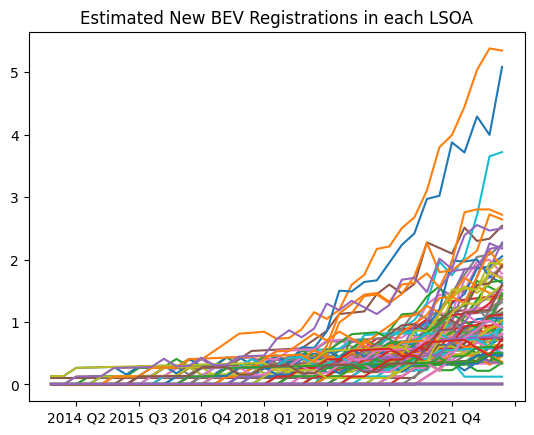

In [24]:
new_bev_lsoa = bev_lsoa_i.diff().add(bev_lsoa_i*bev_retirement_rate) # Approximate new BEV registrations per quarter
new_bev_lsoa[new_bev_lsoa < 0] = 0

# Smooth data by taking a rolling average over 8 quarters (2 years)
smoothed_new_bev_lsoa = new_bev_lsoa.rolling(rolling_average_window).mean()
smoothed_new_bev_lsoa.plot(legend=False, title='Estimated New BEV Registrations in each LSOA')

In [214]:
new_bev_lsoa['E01014399']

2011 Q4         NaN
2012 Q1    0.000000
2012 Q2    0.000000
2012 Q3    0.000000
2012 Q4    0.000000
2013 Q1    0.000000
2013 Q2    0.000000
2013 Q3    0.000000
2013 Q4    0.000000
2014 Q1    0.000000
2014 Q2    0.000000
2014 Q3    0.000000
2014 Q4    0.000000
2015 Q1    0.000000
2015 Q2    0.000000
2015 Q3    0.000000
2015 Q4    0.000000
2016 Q1    0.000000
2016 Q2    0.000000
2016 Q3    1.020833
2016 Q4    0.020833
2017 Q1    0.020833
2017 Q2    1.041667
2017 Q3    0.041667
2017 Q4    0.041667
2018 Q1    1.062500
2018 Q2    0.062500
2018 Q3    1.083333
2018 Q4    0.083333
2019 Q1    0.083333
2019 Q2    1.104167
2019 Q3    0.104167
2019 Q4    0.104167
2020 Q1    1.125000
2020 Q2    1.145833
2020 Q3    1.166667
2020 Q4    0.000000
2021 Q1    1.166667
2021 Q2    1.187500
2021 Q3    3.250000
2021 Q4    2.291667
2022 Q1    2.333333
2022 Q2    0.333333
2022 Q3    2.375000
2022 Q4    2.416667
Name: E01014399, dtype: float64

In [26]:
smoothed_new_bev_lsoa['E01014479']

2011 Q4         NaN
2012 Q1         NaN
2012 Q2         NaN
2012 Q3         NaN
2012 Q4         NaN
2013 Q1         NaN
2013 Q2         NaN
2013 Q3         NaN
2013 Q4    0.132812
2014 Q1    0.135417
2014 Q2    0.265625
2014 Q3    0.270833
2014 Q4    0.276042
2015 Q1    0.281250
2015 Q2    0.286458
2015 Q3    0.291667
2015 Q4    0.296875
2016 Q1    0.302083
2016 Q2    0.307292
2016 Q3    0.312500
2016 Q4    0.317708
2017 Q1    0.322917
2017 Q2    0.328125
2017 Q3    0.333333
2017 Q4    0.338542
2018 Q1    0.343750
2018 Q2    0.221354
2018 Q3    0.223958
2018 Q4    0.226562
2019 Q1    0.229167
2019 Q2    0.104167
2019 Q3    0.104167
2019 Q4    0.104167
2020 Q1    0.104167
2020 Q2    0.104167
2020 Q3    0.104167
2020 Q4    0.231771
2021 Q1    0.361979
2021 Q2    0.367187
2021 Q3    0.755208
2021 Q4    1.151042
2022 Q1    1.299479
2022 Q2    1.286458
2022 Q3    1.434896
2022 Q4    1.585938
Name: E01014479, dtype: float64

<Axes: title={'center': 'Estimated New PHEV Registrations in each LSOA'}>

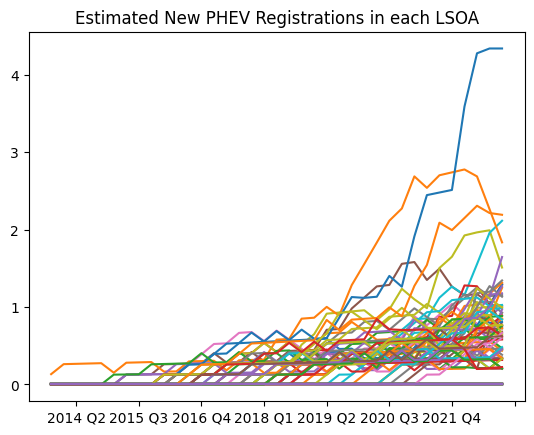

In [27]:
new_phev_lsoa = phev_lsoa_i.diff().add(phev_lsoa_i*phev_retirement_rate) # Approximate new PHEV registrations per quarter
new_phev_lsoa[new_phev_lsoa < 0] = 0

# Smooth data by taking a rolling average over 8 quarters (2 years)
smoothed_new_phev_lsoa = new_phev_lsoa.rolling(rolling_average_window).mean()
smoothed_new_phev_lsoa.plot(legend=False, title='Estimated New PHEV Registrations in each LSOA')

In [28]:
smoothed_new_phev_lsoa['E01014479']

2011 Q4         NaN
2012 Q1         NaN
2012 Q2         NaN
2012 Q3         NaN
2012 Q4         NaN
2013 Q1         NaN
2013 Q2         NaN
2013 Q3         NaN
2013 Q4    0.000000
2014 Q1    0.000000
2014 Q2    0.000000
2014 Q3    0.000000
2014 Q4    0.000000
2015 Q1    0.000000
2015 Q2    0.000000
2015 Q3    0.000000
2015 Q4    0.000000
2016 Q1    0.127083
2016 Q2    0.129167
2016 Q3    0.131250
2016 Q4    0.133333
2017 Q1    0.262500
2017 Q2    0.266667
2017 Q3    0.270833
2017 Q4    0.275000
2018 Q1    0.279167
2018 Q2    0.283333
2018 Q3    0.287500
2018 Q4    0.418750
2019 Q1    0.297917
2019 Q2    0.302083
2019 Q3    0.306250
2019 Q4    0.437500
2020 Q1    0.316667
2020 Q2    0.447917
2020 Q3    0.581250
2020 Q4    0.589583
2021 Q1    0.597917
2021 Q2    0.733333
2021 Q3    0.725000
2021 Q4    0.733333
2022 Q1    0.741667
2022 Q2    0.877083
2022 Q3    0.760417
2022 Q4    0.768750
Name: E01014479, dtype: float64

<Axes: title={'center': 'Estimated New EV Registrations in each LSOA'}>

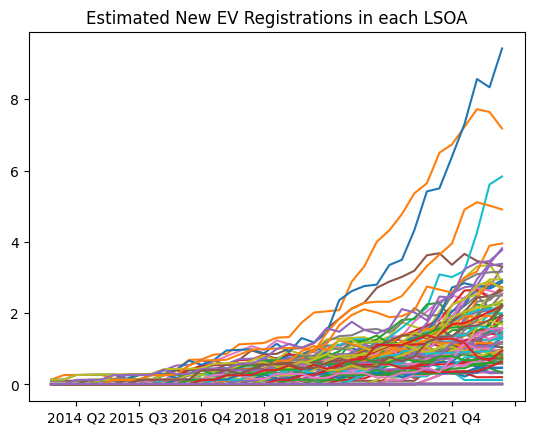

In [29]:
smoothed_new_ev_lsoa = sum([smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])
smoothed_new_ev_lsoa.plot(legend=False, title='Estimated New EV Registrations in each LSOA')

In [215]:
smoothed_new_ev_lsoa['E01014399']

2011 Q4         NaN
2012 Q1         NaN
2012 Q2         NaN
2012 Q3         NaN
2012 Q4         NaN
2013 Q1         NaN
2013 Q2         NaN
2013 Q3         NaN
2013 Q4    0.000000
2014 Q1    0.000000
2014 Q2    0.000000
2014 Q3    0.000000
2014 Q4    0.000000
2015 Q1    0.000000
2015 Q2    0.000000
2015 Q3    0.000000
2015 Q4    0.000000
2016 Q1    0.000000
2016 Q2    0.000000
2016 Q3    0.127604
2016 Q4    0.130208
2017 Q1    0.132812
2017 Q2    0.263021
2017 Q3    0.268229
2017 Q4    0.273438
2018 Q1    0.406250
2018 Q2    0.414062
2018 Q3    0.548958
2018 Q4    0.558854
2019 Q1    0.568750
2019 Q2    0.578646
2019 Q3    0.715625
2019 Q4    0.727604
2020 Q1    0.739583
2020 Q2    1.006250
2020 Q3    0.895833
2020 Q4    0.889583
2021 Q1    1.156250
2021 Q2    1.172917
2021 Q3    1.445312
2021 Q4    1.722917
2022 Q1    2.005208
2022 Q2    1.782813
2022 Q3    1.938021
2022 Q4    2.371354
Name: E01014399, dtype: float64

<Axes: title={'center': 'Estimated New ICE Registrations in each LSOA'}>

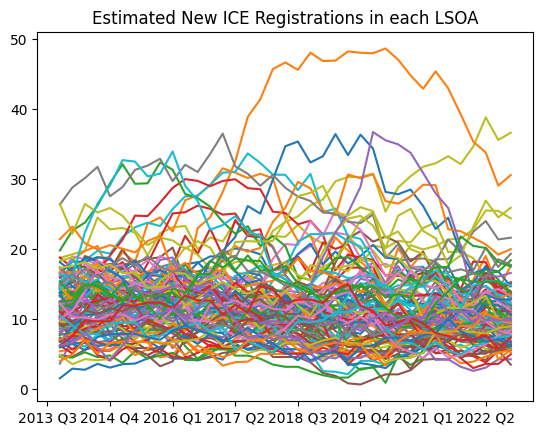

In [31]:
new_ice_lsoa = ice_lsoa_i.diff().add(ice_lsoa_i*ice_retirement_rate) # Approximate new ICE registrations per quarter
new_ice_lsoa[new_ice_lsoa < 0] = 0

# Smooth data by taking a rolling average over 8 quarters (2 years)
smoothed_new_ice_lsoa = new_ice_lsoa.rolling(rolling_average_window).mean()
smoothed_new_ice_lsoa.plot(legend=False, title='Estimated New ICE Registrations in each LSOA')

<Axes: title={'center': 'Estimated New Vehicle Registrations in each LSOA'}>

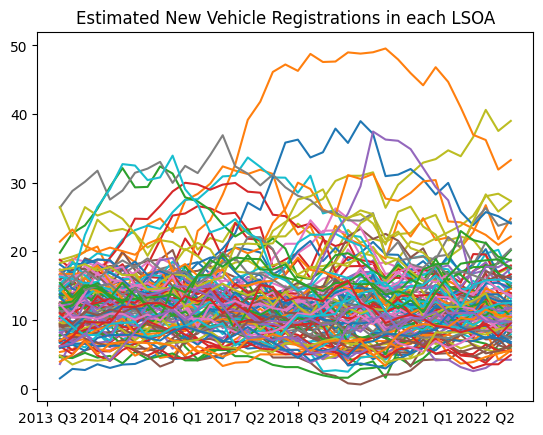

In [32]:
# Approximate new vehicle registrations per quarter (assuming ice retirement rate)
smoothed_new_vehicles_lsoa = sum([smoothed_new_ice_lsoa, smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])
smoothed_new_vehicles_lsoa.plot(legend=False, title='Estimated New Vehicle Registrations in each LSOA')

In [216]:
smoothed_new_vehicles_lsoa['E01014399']

2009 Q4          NaN
2010 Q1          NaN
2010 Q2          NaN
2010 Q3          NaN
2010 Q4          NaN
2011 Q1          NaN
2011 Q2          NaN
2011 Q3          NaN
2011 Q4          NaN
2012 Q1          NaN
2012 Q2          NaN
2012 Q3          NaN
2012 Q4          NaN
2013 Q1          NaN
2013 Q2          NaN
2013 Q3          NaN
2013 Q4    12.389538
2014 Q1    14.653359
2014 Q2    16.225283
2014 Q3    17.691045
2014 Q4    16.346748
2015 Q1    15.269698
2015 Q2    13.014439
2015 Q3    13.663414
2015 Q4    11.406564
2016 Q1     9.499027
2016 Q2    10.733614
2016 Q3     9.705394
2016 Q4    10.985519
2017 Q1    10.856273
2017 Q2    13.156127
2017 Q3    15.085998
2017 Q4    19.195667
2018 Q1    22.980890
2018 Q2    24.281526
2018 Q3    25.217807
2018 Q4    26.797926
2019 Q1    27.636607
2019 Q2    30.257825
2019 Q3    31.011263
2019 Q4    31.011277
2020 Q1    31.514716
2020 Q2    26.344601
2020 Q3    29.693107
2020 Q4    31.289617
2021 Q1    32.924456
2021 Q2    33.437719
2021 Q3    34

# Forecasting the Sales Share for Each Propulsion Type

Given ICE and PHEV New Sale Bans

In [274]:
def calculate_sales_share(target, parent, ban, value_at_ban):
    sales_share = target.divide(parent) # Target = Vehicle time, parent = Parent vehicle type
    sales_share = sales_share.fillna(0) # 0.0/0.0 = NaN. Therefore, I replace the NaNs with 0.

    dates = convert_dates_to_numeric(sales_share) # Historical Dates
    date_range = calculate_date_range(calculate_t0(sales_share), t1=horizon, sample_rate=sample_rate) # Current and Future Dates

    sales_share['Date_numeric'] = dates
    sales_share = sales_share.set_index('Date_numeric')
    sales_share = sales_share.reindex(date_range)

    # Linear Interpolation

    sales_share.loc[ban, :] = value_at_ban # 0 if banned vehicle type, 1 if beneficiary.
    sales_share = sales_share.interpolate()
    return sales_share

In [275]:
# ev_sales_share_lsoa = calculate_sales_share(smoothed_new_ev_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 1)
ice_sales_share_lsoa = calculate_sales_share(smoothed_new_ice_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 0)
# bev_sales_share_lsoa = calculate_sales_share(smoothed_new_bev_lsoa, smoothed_new_ev_lsoa, phev_ban, 1)
phev_sales_share_lsoa = calculate_sales_share(smoothed_new_phev_lsoa, smoothed_new_ev_lsoa, phev_ban, 0)

<Axes: title={'center': 'Share of new vehicles that are ICEs in each LSOA'}, xlabel='Date_numeric'>

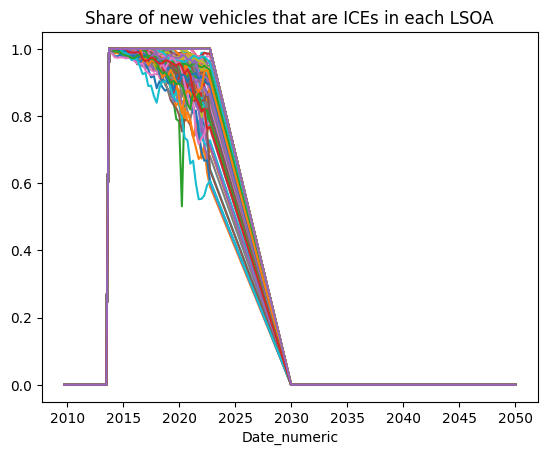

In [276]:
ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA')

<Axes: title={'center': 'Share of new EVs that are PHEVs in each LSOA'}, xlabel='Date_numeric'>

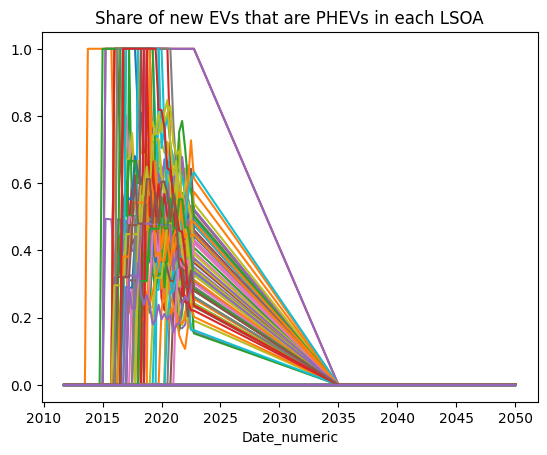

In [277]:
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA')

<Axes: xlabel='Date_numeric'>

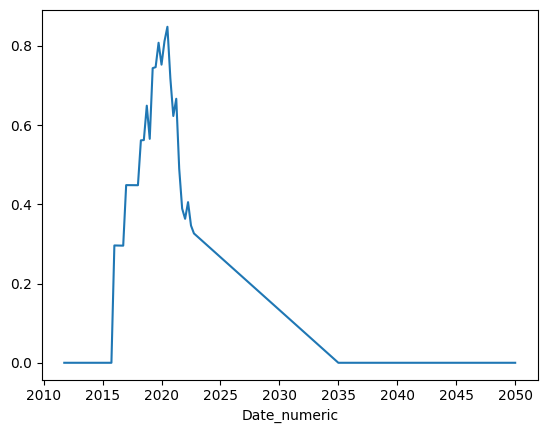

In [278]:
phev_sales_share_lsoa['E01014479'].plot()

# Incorporating Anticipatory behaviour

Have one linear function that trends towards 0 or 1 share of vehicle propulsion type.

Multiply this by an anticipatory function that expontentially increases/decreases up until the relevant ban.

The shape of this curve dictates the extent of anticipatory behaviour prior to a ban.

This should only be used for the legacy vehicles with the disrupter vehicles' sales share being inferred.

As the linear function ends at 0 share on the date of the ban, the exponential function is constrained at 0 at that point. This should look pretty cool!

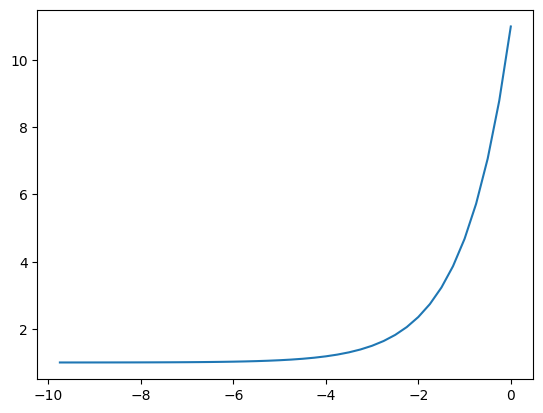

In [279]:
anticipatory_period = 10

x = np.linspace(-(anticipatory_period - (1/sample_rate)), 0, 40) # 10 years (40 quarters)

# ICE Anticipatory Parameters
a = 10
b = 1

y_ice = a * np.exp(b * x) + 1

# PHEV Anticipatory Parameters
c = 10
d = 1

y_phev = c * np.exp(d * x) + 1

plt.plot(x, y_ice)

In [280]:
ice_sales_share_lsoa.loc[ice_ban - 9.75 : ice_ban] = ice_sales_share_lsoa.loc[ice_ban - 9.75 : ice_ban].multiply(y_ice, axis=0)
ev_sales_share_lsoa = 1 - ice_sales_share_lsoa

In [281]:
phev_sales_share_lsoa[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban] = phev_sales_share_lsoa.loc[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban].multiply(y_phev, axis=0)
bev_sales_share_lsoa = 1 - phev_sales_share_lsoa

<Axes: title={'center': 'Share of new vehicles that are ICEs in each LSOA (including anticipatory behaviour)'}, xlabel='Date_numeric'>

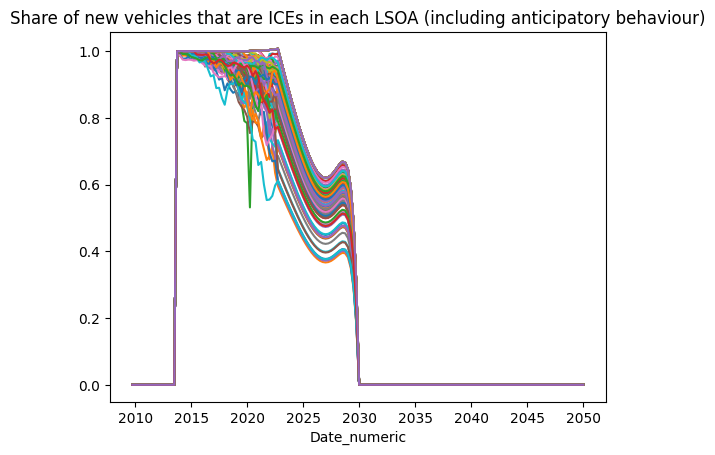

In [282]:
ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA (including anticipatory behaviour)')

<Axes: title={'center': 'Share of new vehicles that are EVs in each LSOA (including anticipatory behaviour)'}, xlabel='Date_numeric'>

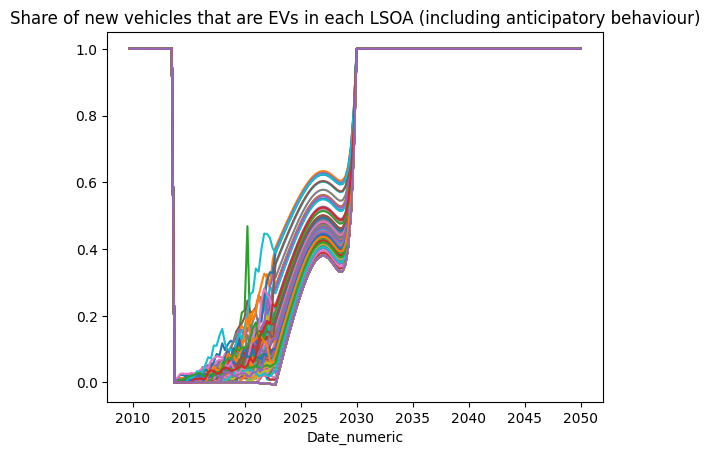

In [283]:
ev_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are EVs in each LSOA (including anticipatory behaviour)')

<Axes: title={'center': 'Share of new EVs that are PHEVs in each LSOA (including anticipatory behaviour)'}, xlabel='Date_numeric'>

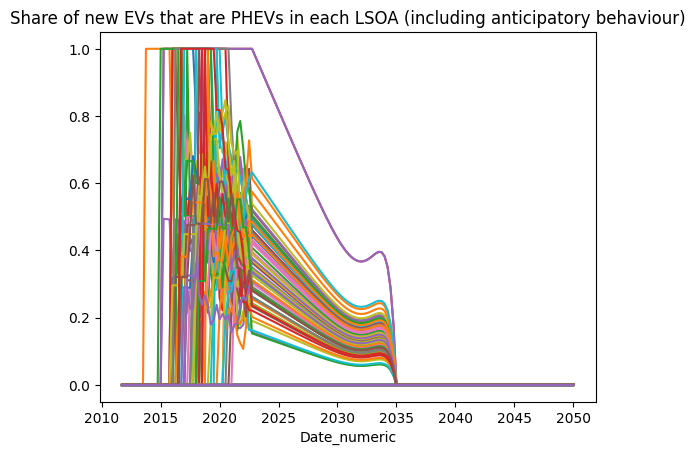

In [284]:
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA (including anticipatory behaviour)')

<Axes: title={'center': 'Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)'}, xlabel='Date_numeric'>

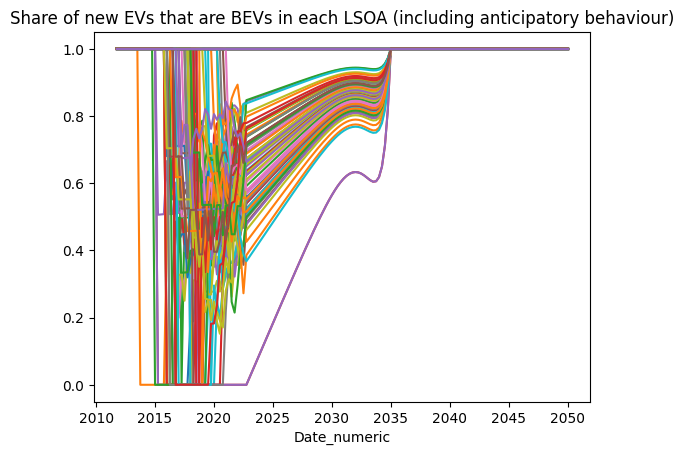

In [285]:
bev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)')

<Axes: xlabel='Date_numeric'>

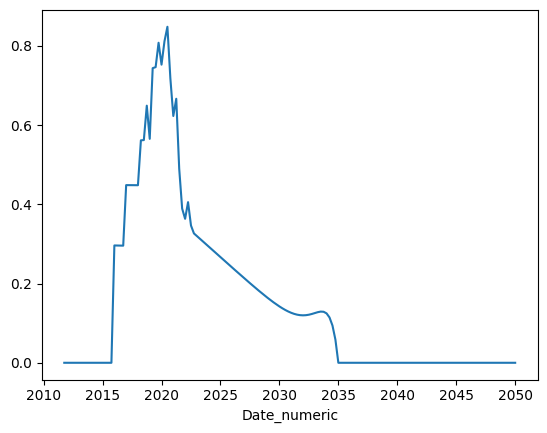

In [286]:
phev_sales_share_lsoa['E01014479'].plot()

<Axes: xlabel='Date_numeric'>

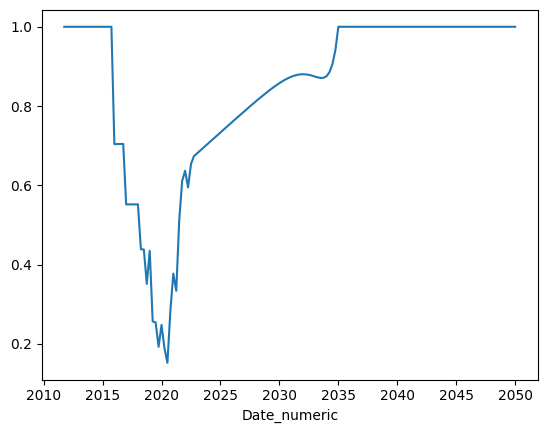

In [287]:
bev_sales_share_lsoa['E01014479'].plot()

# Forecasting New Vehicle Registrations

In [288]:
forecast_dates = calculate_date_range(t0=calculate_t_present(bev_lsoa_i), t1=horizon, sample_rate=4)
forecast_dates

array([2022.75, 2023.  , 2023.25, 2023.5 , 2023.75, 2024.  , 2024.25,
       2024.5 , 2024.75, 2025.  , 2025.25, 2025.5 , 2025.75, 2026.  ,
       2026.25, 2026.5 , 2026.75, 2027.  , 2027.25, 2027.5 , 2027.75,
       2028.  , 2028.25, 2028.5 , 2028.75, 2029.  , 2029.25, 2029.5 ,
       2029.75, 2030.  , 2030.25, 2030.5 , 2030.75, 2031.  , 2031.25,
       2031.5 , 2031.75, 2032.  , 2032.25, 2032.5 , 2032.75, 2033.  ,
       2033.25, 2033.5 , 2033.75, 2034.  , 2034.25, 2034.5 , 2034.75,
       2035.  , 2035.25, 2035.5 , 2035.75, 2036.  , 2036.25, 2036.5 ,
       2036.75, 2037.  , 2037.25, 2037.5 , 2037.75, 2038.  , 2038.25,
       2038.5 , 2038.75, 2039.  , 2039.25, 2039.5 , 2039.75, 2040.  ,
       2040.25, 2040.5 , 2040.75, 2041.  , 2041.25, 2041.5 , 2041.75,
       2042.  , 2042.25, 2042.5 , 2042.75, 2043.  , 2043.25, 2043.5 ,
       2043.75, 2044.  , 2044.25, 2044.5 , 2044.75, 2045.  , 2045.25,
       2045.5 , 2045.75, 2046.  , 2046.25, 2046.5 , 2046.75, 2047.  ,
       2047.25, 2047

In [289]:
new_ev_lsoa_forecast = ev_sales_share_lsoa.loc[forecast_dates, :].multiply(smoothed_new_vehicles_lsoa.iloc[-1], axis='columns')
new_ice_lsoa_forecast = ice_sales_share_lsoa.loc[forecast_dates, :].multiply(smoothed_new_vehicles_lsoa.iloc[-1], axis='columns')
new_bev_lsoa_forecast = bev_sales_share_lsoa.loc[forecast_dates, :].multiply(new_ev_lsoa_forecast, axis='columns')
new_phev_lsoa_forecast = phev_sales_share_lsoa.loc[forecast_dates, :].multiply(new_ev_lsoa_forecast, axis='columns')

new_ev_lsoa_forecast[new_ev_lsoa_forecast < 0] = 0
new_ice_lsoa_forecast[new_ice_lsoa_forecast < 0] = 0
new_bev_lsoa_forecast[new_bev_lsoa_forecast < 0] = 0
new_phev_lsoa_forecast[new_phev_lsoa_forecast < 0] = 0

<Axes: title={'center': 'Forecasts for the number of New EVs by LSOA'}, xlabel='Date_numeric'>

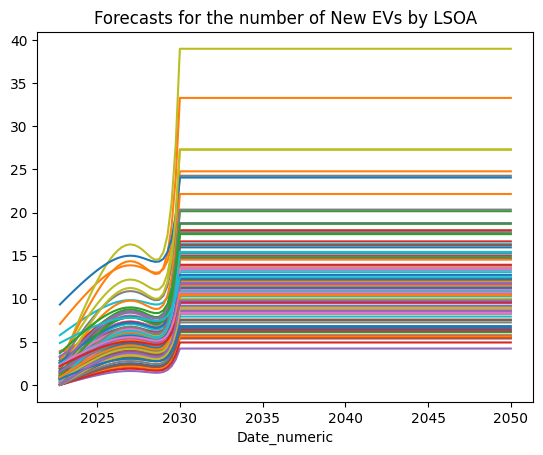

In [290]:
new_ev_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New EVs by LSOA')

<Axes: title={'center': 'Forecasts for the number of New ICEs by LSOA'}, xlabel='Date_numeric'>

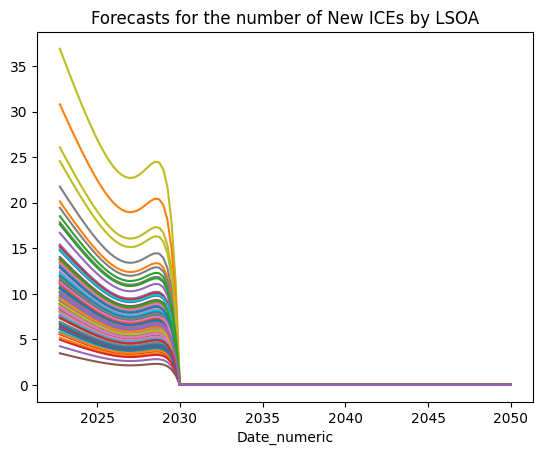

In [291]:
new_ice_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New ICEs by LSOA')

<Axes: title={'center': 'Forecasts for the number of New BEVs by LSOA'}, xlabel='Date_numeric'>

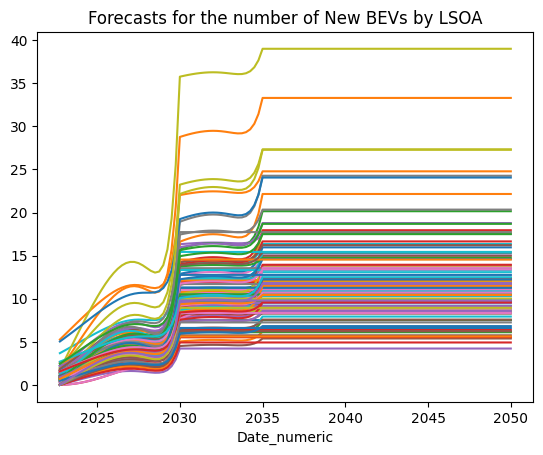

In [292]:
new_bev_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New BEVs by LSOA')

<Axes: title={'center': 'Forecasts for the number of New PHEVs by LSOA'}, xlabel='Date_numeric'>

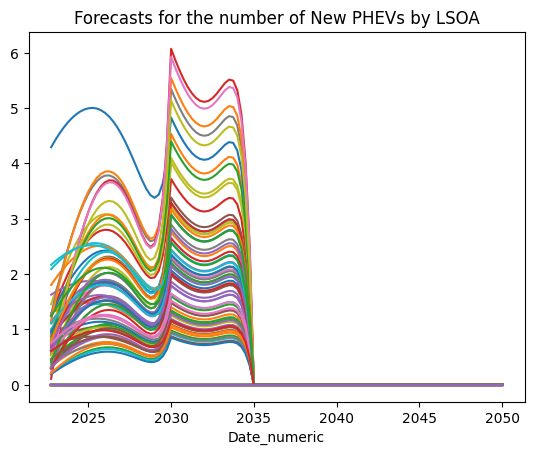

In [293]:
new_phev_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New PHEVs by LSOA')

In [294]:
new_bev_lsoa_forecast['E01014479']

Date_numeric
2022.75     1.545990
2023.00     1.747498
2023.25     1.950393
2023.50     2.154107
2023.75     2.357951
             ...    
2049.00    10.706408
2049.25    10.706408
2049.50    10.706408
2049.75    10.706408
2050.00    10.706408
Name: E01014479, Length: 110, dtype: float64

# Combining Vehicle Retirements

In [295]:
bev_lsoa_initial = bev_lsoa_i.iloc[-1]
phev_lsoa_initial = phev_lsoa_i.iloc[-1]
ice_lsoa_initial = ice_lsoa_i.iloc[-1]

In [296]:
bev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=bev_lsoa_i.columns, dtype=float)
phev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=phev_lsoa_i.columns, dtype=float)
ice_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=ice_lsoa_i.columns, dtype=float)

# Populate forecast with inital starting registrations
bev_forecast_lsoa.iloc[0] = bev_lsoa_i.iloc[-1]
phev_forecast_lsoa.iloc[0] = phev_lsoa_i.iloc[-1]
ice_forecast_lsoa.iloc[0] = ice_lsoa_i.iloc[-1]

Using .iloc causes some weird stuff to happen. Using .loc instead seems to solve the issue.

In [297]:
for i in range(1, len(forecast_dates)):
    bev_forecast_lsoa.loc[forecast_dates[i]] = bev_forecast_lsoa.loc[forecast_dates[i-1]] + new_bev_lsoa_forecast.loc[forecast_dates[i]] - (bev_retirement_rate * bev_forecast_lsoa.loc[forecast_dates[i-1]])
    phev_forecast_lsoa.loc[forecast_dates[i]] = phev_forecast_lsoa.loc[forecast_dates[i-1]] + new_phev_lsoa_forecast.loc[forecast_dates[i]] - (phev_retirement_rate * phev_forecast_lsoa.loc[forecast_dates[i-1]])
    ice_forecast_lsoa.loc[forecast_dates[i]] = ice_forecast_lsoa.loc[forecast_dates[i-1]] + new_ice_lsoa_forecast.loc[forecast_dates[i]] - (ice_retirement_rate * ice_forecast_lsoa.loc[forecast_dates[i-1]])

bev_forecast_lsoa = round(bev_forecast_lsoa)
phev_forecast_lsoa = round(phev_forecast_lsoa)
ice_forecast_lsoaa = round(ice_forecast_lsoa)

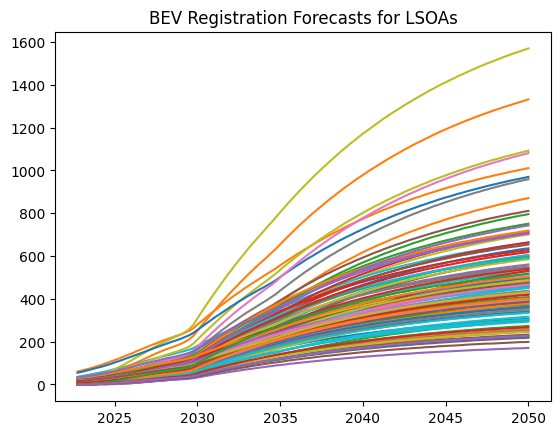

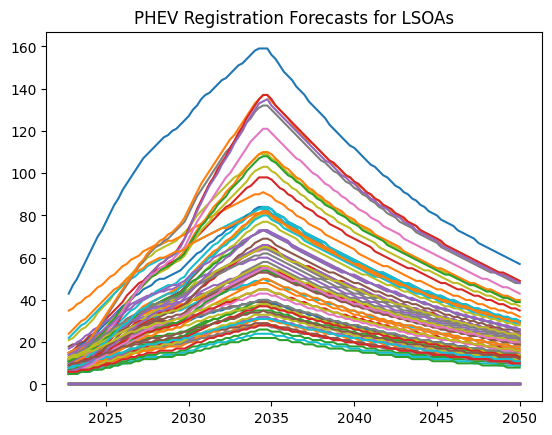

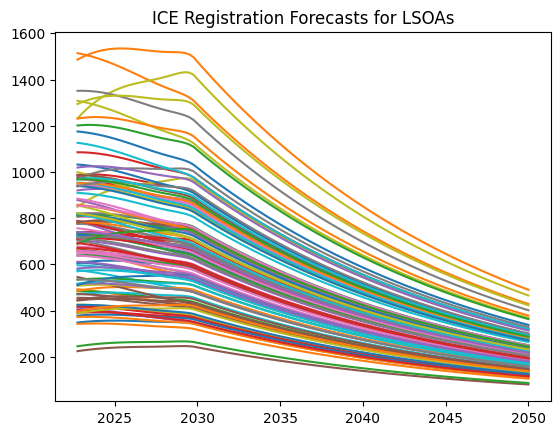

In [298]:
bev_forecast_lsoa.plot(legend=False, title='BEV Registration Forecasts for LSOAs')
phev_forecast_lsoa.plot(legend=False, title = 'PHEV Registration Forecasts for LSOAs')
ice_forecast_lsoa.plot(legend=False, title = 'ICE Registration Forecasts for LSOAs')
plt.show()

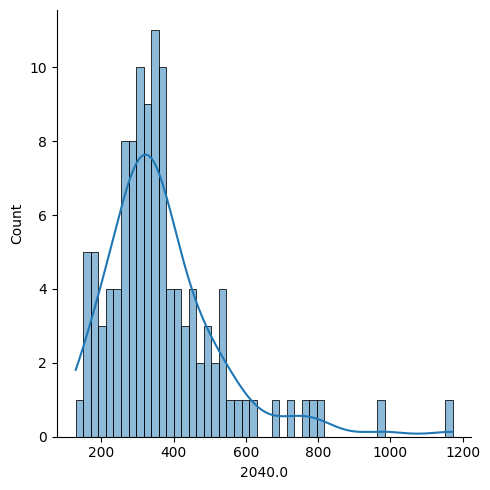

In [299]:
sns.displot(bev_forecast_lsoa.loc[2040], kde=True, bins=50)

# Forecasting for Individual LSOAs

Text(0.5, 1.0, 'Vehicle Stock Forecasts for LSOA E01014381')

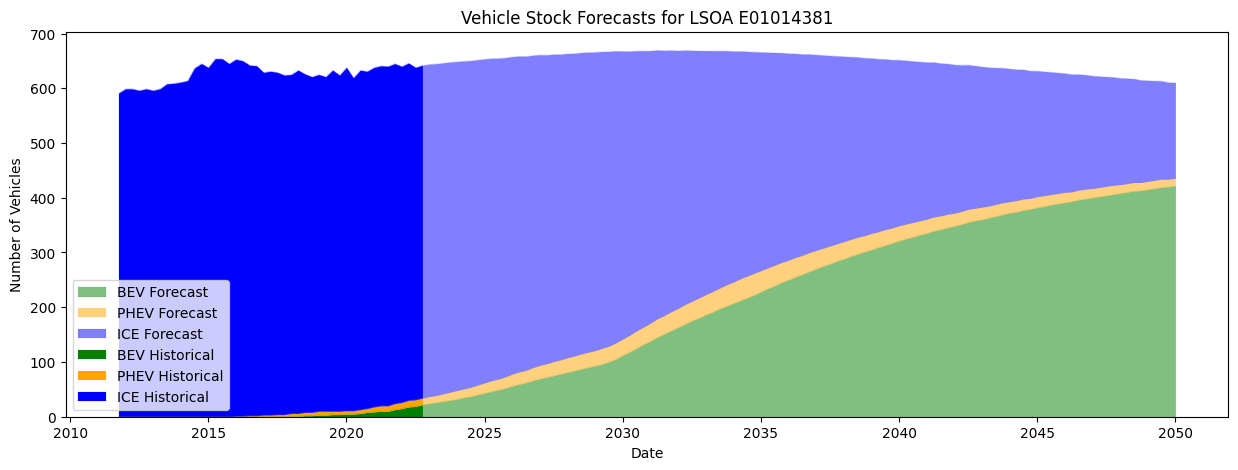

In [300]:
id = 10
bev_forecast_single_lsoa = bev_forecast_lsoa.iloc[:, id]
bev_forecast_single_lsoa.name = 'BEV Forecast'
phev_forecast_single_lsoa = phev_forecast_lsoa.iloc[:, id]
phev_forecast_single_lsoa.name = 'PHEV Forecast'
ice_forecast_single_lsoa = ice_forecast_lsoa.iloc[:, id]
ice_forecast_single_lsoa.name = 'ICE Forecast'

future_vehicles = pd.concat([bev_forecast_single_lsoa, phev_forecast_single_lsoa, ice_forecast_single_lsoa], axis=1)

historical_ice_single_lsoa = ice_lsoa_i.iloc[:, id]
historical_ice_single_lsoa.name = 'ICE Historical'
historical_bev_single_lsoa = bev_lsoa_i.iloc[:, id]
historical_bev_single_lsoa.name = 'BEV Historical'
historical_phev_single_lsoa = phev_lsoa_i.iloc[:, id]
historical_phev_single_lsoa.name = 'PHEV Historical'

historical_vehicles = pd.concat([historical_bev_single_lsoa, historical_phev_single_lsoa, historical_ice_single_lsoa], axis=1).dropna()
historical_dates = convert_dates_to_numeric(historical_vehicles)
historical_vehicles['dates_numeric'] = historical_dates
historical_vehicles = historical_vehicles.set_index('dates_numeric')

fig, ax = plt.subplots(figsize=(15, 5))
future_vehicles.plot.area(ax=ax, color=['green', 'orange', 'blue'], alpha=0.5, linewidth=0.1)
historical_vehicles.plot.area(ax=ax, color=['green', 'orange', 'blue'], linewidth=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('Vehicle Stock Forecasts for LSOA {}'.format(bev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'Vehicle Stock Forecasts for LSOA E01014381')

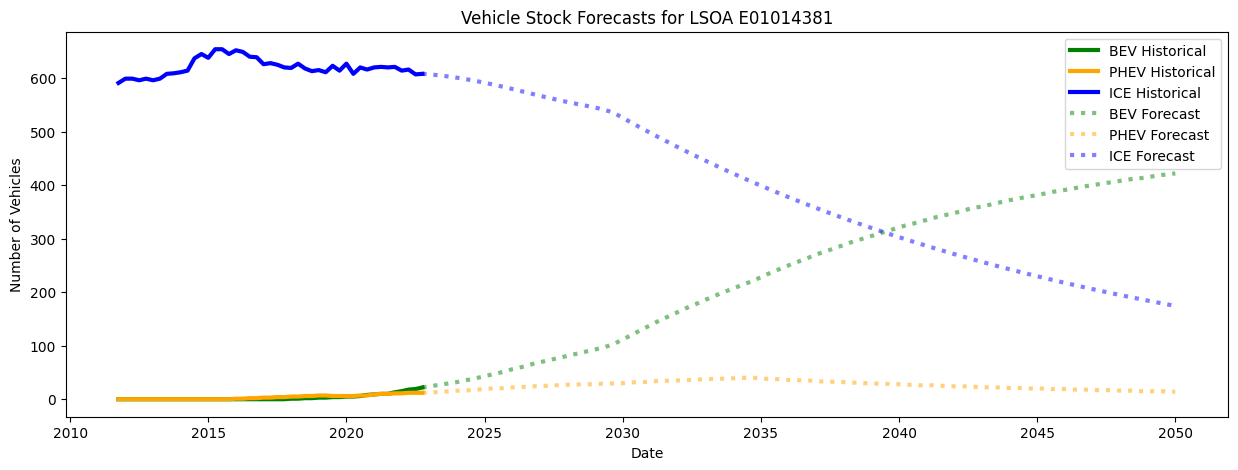

In [301]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles.plot(ax=ax, color=['green', 'orange', 'blue'], linewidth=3)
future_vehicles.plot(ax=ax, color=['green', 'orange', 'blue'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('Vehicle Stock Forecasts for LSOA {}'.format(bev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'BEV Stock Forecasts for LSOA E01014381')

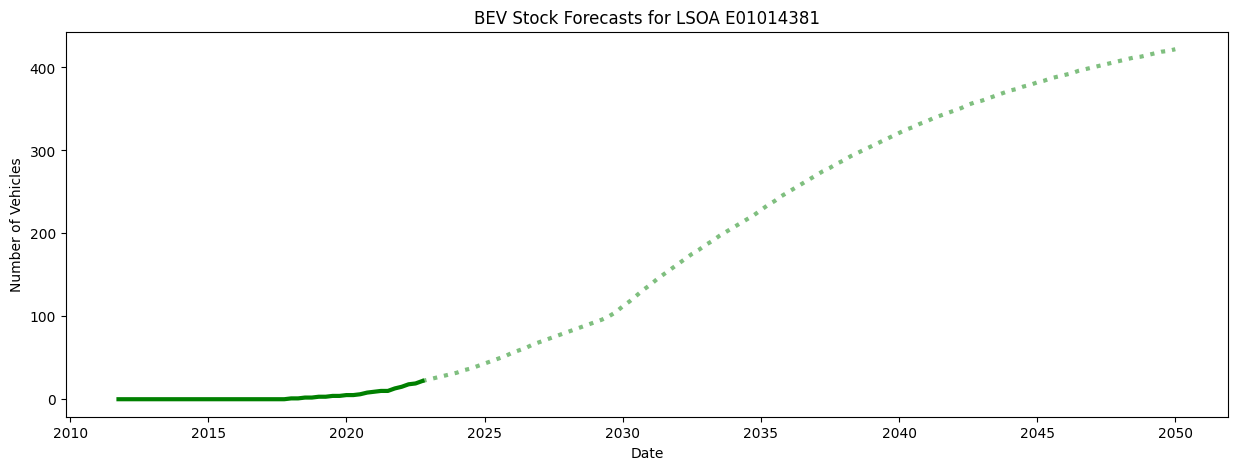

In [302]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles['BEV Historical'].plot(ax=ax, color=['green'], linewidth=3)
future_vehicles['BEV Forecast'].plot(ax=ax, color=['green'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('BEV Stock Forecasts for LSOA {}'.format(bev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'PHEV Stock Forecasts for LSOA E01014381')

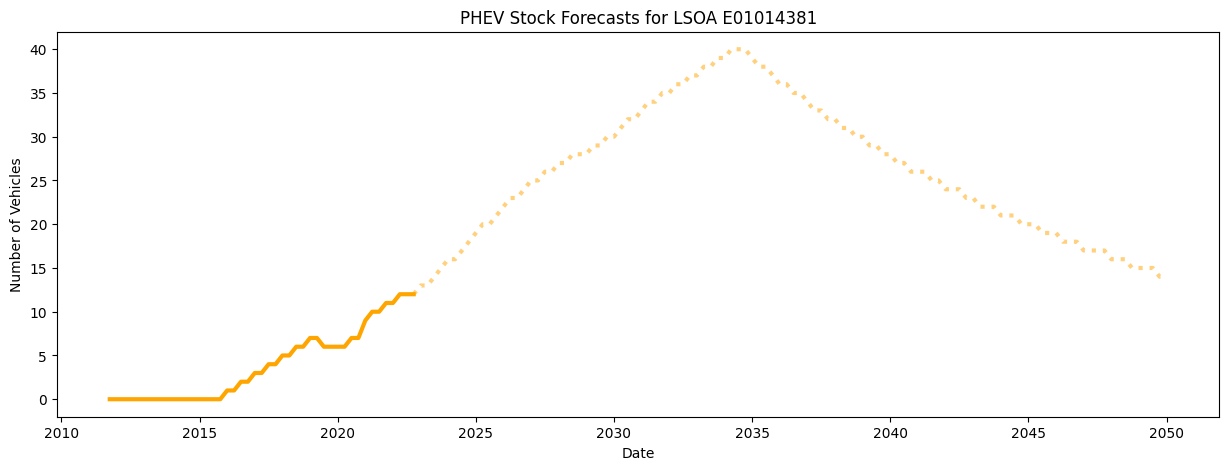

In [303]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles['PHEV Historical'].plot(ax=ax, color=['orange'], linewidth=3)
future_vehicles['PHEV Forecast'].plot(ax=ax, color=['orange'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('PHEV Stock Forecasts for LSOA {}'.format(phev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'ICE Stock Forecasts for LSOA E01014381')

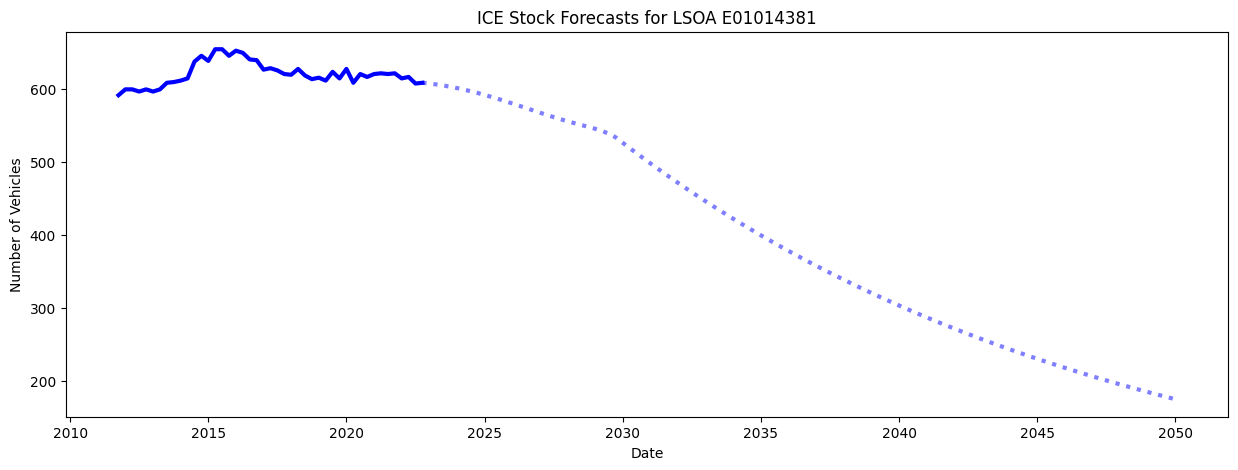

In [304]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles['ICE Historical'].plot(ax=ax, color=['blue'], linewidth=3)
future_vehicles['ICE Forecast'].plot(ax=ax, color=['blue'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('ICE Stock Forecasts for LSOA {}'.format(ice_forecast_lsoa.iloc[:, id].name))

# Map Plots

In [305]:
import folium
# For geocoding
from geopy.geocoders import Nominatim

In [306]:
lsoa_geo = (
    gpd.read_file('../../data/spatial_data/lsoa_data/Lower_Layer_Super_Output_Areas__December_2011__Boundaries_Full_Clipped__BFC__EW_V3.shp')
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on = 'LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns=['LAD22NM'])
    .set_index('LSOA11CD', drop=False)
    .to_crs('EPSG:4326') # Change CRS
) 

# Drop duplicate rows
lsoa_geo = lsoa_geo[~lsoa_geo.index.duplicated(keep='first')]

lsoa_geo.head()

OBJECTID   LSOA11CD                           LSOA11NM   BNG_E  \
LSOA11CD                                                                    
E01014370     13973  E01014370  Bath and North East Somerset 007A  375084   
E01014371     13974  E01014371  Bath and North East Somerset 007B  375328   
E01014372     13975  E01014372  Bath and North East Somerset 007C  374832   
E01014373     13976  E01014373  Bath and North East Somerset 010A  377791   
E01014374     13977  E01014374  Bath and North East Somerset 010B  378059   

            BNG_N    LONG_      LAT    Shape_Leng    Shape__Are    Shape__Len  \
LSOA11CD                                                                        
E01014370  164994 -2.35941  51.3834   4168.323516  3.770303e+05   4168.323516   
E01014371  164841 -2.35590  51.3821   4146.079795  4.094906e+05   4146.079795   
E01014372  165378 -2.36306  51.3869   2870.144109  1.668015e+05   2870.144109   
E01014373  167691 -2.32068  51.4078   6720.118267  1.059979e+06   6720.118267   
E01014374  166769 -2.31677  51.3995  19927.251976  5.002127e+06  19927.251976   

                                                    geometry  
LSOA11CD                                                      
E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  
E01014371  POLYGON ((-2.35166 51.38534, -2.35158 51.38530...  
E01014372  POLYGON ((-2.35597 51.38950, -2.35587 51.38942...  
E01014373  POLYGON ((-2.32115 51.41364, -2.32114 51.41364...  
E01014374  POLYGON ((-2.30592 51.40806, -2.30591 51.40806...

In [308]:
geolocator = Nominatim(user_agent="iyzf20@bath.ac.uk") # Using the Nominatim geolocator from OpenStreetMap

location = geolocator.geocode(LAD)

loc_lat = location.point.latitude
loc_lon = location.point.longitude

print("Latitude:", loc_lat)
print("Longitude:", loc_lon)

Latitude: 51.35632375
Longitude: -2.486661424502094


In [309]:
bev_forecast_lsoa_geo = gpd.GeoDataFrame(data=bev_forecast_lsoa.T, crs='EPSG:4326', geometry=lsoa_geo['geometry'])
bev_forecast_lsoa_geo['LSOA11CD'] = bev_forecast_lsoa_geo.index

ice_forecast_lsoa_geo = gpd.GeoDataFrame(data=ice_forecast_lsoa.T, crs='EPSG:4326', geometry=lsoa_geo['geometry'])
ice_forecast_lsoa_geo['LSOA11CD'] = ice_forecast_lsoa_geo.index

phev_forecast_lsoa_geo = gpd.GeoDataFrame(data=phev_forecast_lsoa.T, crs='EPSG:4326', geometry=lsoa_geo['geometry'])
phev_forecast_lsoa_geo['LSOA11CD'] = phev_forecast_lsoa_geo.index

bev_forecast_lsoa_geo.head()

2022.75  2023.0  2023.25  2023.5  2023.75  2024.0  2024.25  2024.5  \
LSOA11CD                                                                        
E01014370      9.0    10.0     11.0    12.0     13.0    15.0     16.0    18.0   
E01014371      5.0     6.0      6.0     7.0      8.0     9.0     10.0    11.0   
E01014372      7.0     7.0      8.0     8.0      9.0    10.0     11.0    12.0   
E01014373     10.0    11.0     12.0    14.0     16.0    18.0     20.0    23.0   
E01014374     20.0    22.0     24.0    27.0     30.0    32.0     36.0    39.0   

           2024.75  2025.0  ...  2048.25  2048.5  2048.75  2049.0  2049.25  \
LSOA11CD                    ...                                              
E01014370     20.0    22.0  ...    299.0   300.0    302.0   303.0    304.0   
E01014371     12.0    13.0  ...    238.0   240.0    241.0   242.0    243.0   
E01014372     13.0    14.0  ...    288.0   290.0    291.0   293.0    294.0   
E01014373     26.0    29.0  ...    481.0   483.0    485.0   487.0    489.0   
E01014374     42.0    46.0  ...    544.0   546.0    549.0   551.0    554.0   

           2049.5  2049.75  2050.0  \
LSOA11CD                             
E01014370   305.0    306.0   307.0   
E01014371   244.0    245.0   246.0   
E01014372   295.0    297.0   298.0   
E01014373   491.0    493.0   495.0   
E01014374   556.0    558.0   561.0   

                                                    geometry   LSOA11CD  
LSOA11CD                                                                 
E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  E01014370  
E01014371  POLYGON ((-2.35166 51.38534, -2.35158 51.38530...  E01014371  
E01014372  POLYGON ((-2.35597 51.38950, -2.35587 51.38942...  E01014372  
E01014373  POLYGON ((-2.32115 51.41364, -2.32114 51.41364...  E01014373  
E01014374  POLYGON ((-2.30592 51.40806, -2.30591 51.40806...  E01014374  

[5 rows x 112 columns]

In [310]:
bev_forecast_lsoa_geo.describe()

2022.75     2023.00     2023.25     2023.50     2023.75     2024.00  \
count  115.000000  115.000000  115.000000  115.000000  115.000000  115.000000   
mean    11.026087   11.947826   13.243478   14.747826   16.530435   18.530435   
std     10.302836   11.040471   11.792498   12.578067   13.377332   14.203608   
min      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
25%      5.000000    6.000000    6.500000    7.000000    8.500000   10.000000   
50%      9.000000   10.000000   12.000000   13.000000   15.000000   16.000000   
75%     15.500000   17.000000   18.500000   20.500000   23.000000   25.000000   
max     61.000000   65.000000   70.000000   75.000000   81.000000   87.000000   

          2024.25     2024.50     2024.75     2025.00  ...      2047.75  \
count  115.000000  115.000000  115.000000  115.000000  ...   115.000000   
mean    20.678261   23.104348   25.747826   28.556522  ...   476.286957   
std     15.075569   16.031971   17.016423   18.107957  ...   215.531280   
min      1.000000    1.000000    2.000000    2.000000  ...   164.000000   
25%     11.000000   13.000000   15.000000   16.500000  ...   349.500000   
50%     18.000000   21.000000   24.000000   26.000000  ...   438.000000   
75%     28.000000   31.000000   33.500000   37.000000  ...   550.000000   
max     93.000000  100.000000  107.000000  114.000000  ...  1507.000000   

           2048.00      2048.25      2048.50      2048.75      2049.00  \
count   115.000000   115.000000   115.000000   115.000000   115.000000   
mean    478.730435   481.034783   483.382609   485.652174   487.878261   
std     216.711682   217.794605   218.960726   220.039432   221.085446   
min     165.000000   166.000000   166.000000   167.000000   168.000000   
25%     351.000000   353.000000   354.000000   356.000000   357.000000   
50%     440.000000   442.000000   444.000000   446.000000   448.000000   
75%     552.500000   555.500000   557.500000   560.500000   563.000000   
max    1515.000000  1522.000000  1530.000000  1537.000000  1544.000000   

           2049.25      2049.50      2049.75      2050.00  
count   115.000000   115.000000   115.000000   115.000000  
mean    490.043478   492.173913   494.252174   496.339130  
std     222.130805   223.156041   224.180412   225.089841  
min     169.000000   169.000000   170.000000   171.000000  
25%     359.000000   360.000000   361.500000   363.000000  
50%     450.000000   452.000000   454.000000   456.000000  
75%     565.500000   568.000000   570.500000   573.000000  
max    1551.000000  1557.000000  1564.000000  1570.000000  

[8 rows x 110 columns]

In [311]:
year = 2025.0 # Need to specify decimals
forecast_data = bev_forecast_lsoa_geo

m1 = folium.Map(location=[loc_lat, loc_lon], tiles='openstreetmap', zoom_start=12)

cp = folium.Choropleth(geo_data = forecast_data,
                       data = forecast_data,
                       columns = ['LSOA11CD', year],
                       key_on = 'feature.properties.LSOA11CD',
                       fill_color = "YlGn",
                       nan_fill_opacity = 0.5,
                       fill_opacity = 0.7,
                       highlight = True,).add_to(m1)
folium.GeoJsonTooltip(['LSOA11CD', '{}'.format(year)]).add_to(cp.geojson)
folium.LayerControl().add_to(m1)
m1

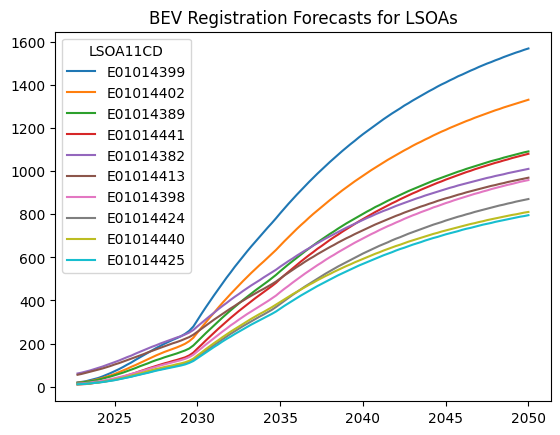

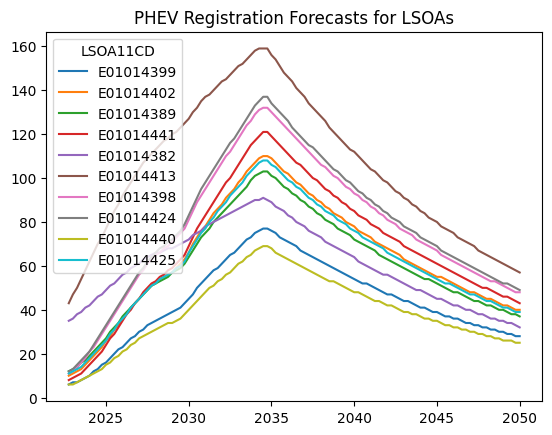

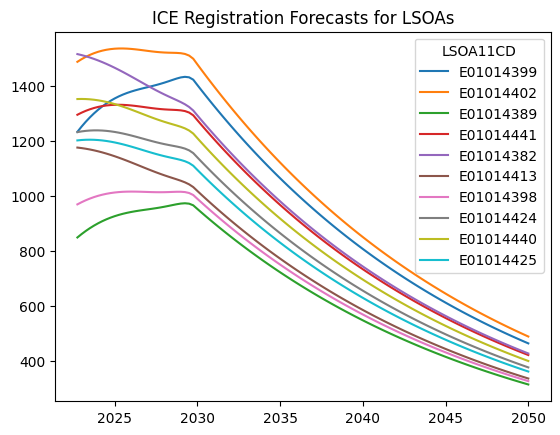

In [312]:
# Plotting the adoption curves for the 10 LSOAs with the largest 2050 BEV adoption
bev_forecast_lsoa[bev_forecast_lsoa.max().sort_values(ascending=False).index[:10]].plot(title='BEV Registration Forecasts for LSOAs')
phev_forecast_lsoa[bev_forecast_lsoa.max().sort_values(ascending=False).index[:10]].plot(title='PHEV Registration Forecasts for LSOAs')
ice_forecast_lsoa[bev_forecast_lsoa.max().sort_values(ascending=False).index[:10]].plot(title='ICE Registration Forecasts for LSOAs')
plt.show()

# Time Slider Map

In [313]:
bev_forecast_lsoa_geo.head()

2022.75  2023.0  2023.25  2023.5  2023.75  2024.0  2024.25  2024.5  \
LSOA11CD                                                                        
E01014370      9.0    10.0     11.0    12.0     13.0    15.0     16.0    18.0   
E01014371      5.0     6.0      6.0     7.0      8.0     9.0     10.0    11.0   
E01014372      7.0     7.0      8.0     8.0      9.0    10.0     11.0    12.0   
E01014373     10.0    11.0     12.0    14.0     16.0    18.0     20.0    23.0   
E01014374     20.0    22.0     24.0    27.0     30.0    32.0     36.0    39.0   

           2024.75  2025.0  ...  2048.25  2048.5  2048.75  2049.0  2049.25  \
LSOA11CD                    ...                                              
E01014370     20.0    22.0  ...    299.0   300.0    302.0   303.0    304.0   
E01014371     12.0    13.0  ...    238.0   240.0    241.0   242.0    243.0   
E01014372     13.0    14.0  ...    288.0   290.0    291.0   293.0    294.0   
E01014373     26.0    29.0  ...    481.0   483.0    485.0   487.0    489.0   
E01014374     42.0    46.0  ...    544.0   546.0    549.0   551.0    554.0   

           2049.5  2049.75  2050.0  \
LSOA11CD                             
E01014370   305.0    306.0   307.0   
E01014371   244.0    245.0   246.0   
E01014372   295.0    297.0   298.0   
E01014373   491.0    493.0   495.0   
E01014374   556.0    558.0   561.0   

                                                    geometry   LSOA11CD  
LSOA11CD                                                                 
E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  E01014370  
E01014371  POLYGON ((-2.35166 51.38534, -2.35158 51.38530...  E01014371  
E01014372  POLYGON ((-2.35597 51.38950, -2.35587 51.38942...  E01014372  
E01014373  POLYGON ((-2.32115 51.41364, -2.32114 51.41364...  E01014373  
E01014374  POLYGON ((-2.30592 51.40806, -2.30591 51.40806...  E01014374  

[5 rows x 112 columns]

In [314]:
bev_forecast_lsoa_geo.iloc[0]

2022.75                                                   9.0
2023.0                                                   10.0
2023.25                                                  11.0
2023.5                                                   12.0
2023.75                                                  13.0
                                  ...                        
2049.5                                                  305.0
2049.75                                                 306.0
2050.0                                                  307.0
geometry    POLYGON ((-2.3564713010890004 51.3892019693447...
LSOA11CD                                            E01014370
Name: E01014370, Length: 112, dtype: object

In [315]:
pd.to_datetime(melted_df['Date'])

0       1970-01-01 00:00:00.000002022
1       1970-01-01 00:00:00.000002023
2       1970-01-01 00:00:00.000002023
3       1970-01-01 00:00:00.000002023
4       1970-01-01 00:00:00.000002023
                     ...             
12645   1970-01-01 00:00:00.000002049
12646   1970-01-01 00:00:00.000002049
12647   1970-01-01 00:00:00.000002049
12648   1970-01-01 00:00:00.000002049
12649   1970-01-01 00:00:00.000002050
Name: Date, Length: 12650, dtype: datetime64[ns]

In [316]:
# Melt the DataFrame to convert the quarter columns into separate rows
melted_df = pd.melt(bev_forecast_lsoa_geo, id_vars=["LSOA11CD", "geometry"], var_name="Date", value_name="Number of Vehicles")

# Sort the DataFrame by LSOA name and Quarter
melted_df = melted_df.sort_values(["LSOA11CD", "Date"])

# Reset the index of the DataFrame
melted_df = melted_df.reset_index(drop=True)

# melted_df['Date'] = pd.to_datetime(melted_df['Date']).astype(int) / 10**9

melted_df.head()

LSOA11CD                                           geometry     Date  \
0  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2022.75   
1  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.0   
2  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.25   
3  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.5   
4  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.75   

   Number of Vehicles  
0                 9.0  
1                10.0  
2                11.0  
3                12.0  
4                13.0

In [317]:
melted_df.head()

LSOA11CD                                           geometry     Date  \
0  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2022.75   
1  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.0   
2  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.25   
3  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.5   
4  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.75   

   Number of Vehicles  
0                 9.0  
1                10.0  
2                11.0  
3                12.0  
4                13.0

In [318]:
int(melted_df['Date'].iloc[0])

2022

In [319]:
melted_df['Date'].iloc[0] - int(melted_df['Date'].iloc[0])

0.75

In [320]:
int((melted_df['Date'].iloc[0] - int(melted_df['Date'].iloc[0])) * 12) + 1

10

In [321]:
import datetime as datetime
# Define a function to convert quarter dates to Unix timestamps
def convert_quarter_to_unix_timestamp(quarter):
    year = int(quarter)
    quarter_fraction = quarter - year
    month = int(quarter_fraction * 12) + 1
    day = 1
    dt = datetime.datetime(year, month, day)
    return int(dt.timestamp())

# Apply the function to the "Quarter" column to convert the quarter dates to Unix timestamps
melted_df["Unix Timestamp"] = melted_df["Date"].apply(convert_quarter_to_unix_timestamp)

In [322]:
melted_df

LSOA11CD                                           geometry     Date  \
0      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2022.75   
1      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.0   
2      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.25   
3      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.5   
4      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.75   
...          ...                                                ...      ...   
12645  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...   2049.0   
12646  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...  2049.25   
12647  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...   2049.5   
12648  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...  2049.75   
12649  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...   2050.0   

       Number of Vehicles  Unix Timestamp  
0                     9.0      1664578800  
1                    10.0      1672531200  
2                    11.0      1680303600  
3                    12.0      1688166000  
4                    13.0      1696114800  
...                   ...             ...  
12645               390.0      2493072000  
12646               392.0      2500844400  
12647               393.0      2508706800  
12648               395.0      2516655600  
12649               396.0      2524608000  

[12650 rows x 5 columns]

In [323]:
import branca.colormap as cm
max_colour = max(melted_df['Number of Vehicles'])
min_colour = min(melted_df['Number of Vehicles'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
melted_df['colour'] = melted_df['Number of Vehicles'].map(cmap)
melted_df.head()

LSOA11CD                                           geometry     Date  \
0  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2022.75   
1  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.0   
2  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.25   
3  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.5   
4  E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.75   

   Number of Vehicles  Unix Timestamp     colour  
0                 9.0      1664578800  #ffffcaff  
1                10.0      1672531200  #ffffcaff  
2                11.0      1680303600  #fffecaff  
3                12.0      1688166000  #fffecaff  
4                13.0      1696114800  #fffec9ff

In [324]:
lsoa_list = melted_df['LSOA11CD'].unique().tolist()
lsoa_list

['E01014370',
 'E01014371',
 'E01014372',
 'E01014373',
 'E01014374',
 'E01014375',
 'E01014376',
 'E01014377',
 'E01014379',
 'E01014380',
 'E01014381',
 'E01014382',
 'E01014383',
 'E01014384',
 'E01014385',
 'E01014386',
 'E01014387',
 'E01014388',
 'E01014389',
 'E01014390',
 'E01014391',
 'E01014392',
 'E01014393',
 'E01014394',
 'E01014395',
 'E01014396',
 'E01014397',
 'E01014398',
 'E01014399',
 'E01014400',
 'E01014401',
 'E01014402',
 'E01014403',
 'E01014404',
 'E01014405',
 'E01014407',
 'E01014409',
 'E01014410',
 'E01014411',
 'E01014412',
 'E01014413',
 'E01014414',
 'E01014415',
 'E01014416',
 'E01014417',
 'E01014418',
 'E01014419',
 'E01014420',
 'E01014421',
 'E01014422',
 'E01014423',
 'E01014424',
 'E01014425',
 'E01014426',
 'E01014427',
 'E01014428',
 'E01014429',
 'E01014430',
 'E01014431',
 'E01014432',
 'E01014433',
 'E01014434',
 'E01014435',
 'E01014436',
 'E01014437',
 'E01014438',
 'E01014439',
 'E01014440',
 'E01014441',
 'E01014442',
 'E01014443',
 'E010

In [325]:
lsoa_idx = range(len(lsoa_list))
lsoa_idx

range(0, 115)

In [326]:
region_list = melted_df['LSOA11CD'].unique().tolist()
region_idx = range(len(region_list))

style_dict = {}
for i in lsoa_idx:
    lsoa = lsoa_list[i]
    result = melted_df[melted_df['LSOA11CD'] == lsoa]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['Unix Timestamp']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [327]:
melted_df

LSOA11CD                                           geometry     Date  \
0      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2022.75   
1      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.0   
2      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.25   
3      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   2023.5   
4      E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...  2023.75   
...          ...                                                ...      ...   
12645  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...   2049.0   
12646  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...  2049.25   
12647  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...   2049.5   
12648  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...  2049.75   
12649  E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...   2050.0   

       Number of Vehicles  Unix Timestamp     colour  
0                     9.0      1664578800  #ffffcaff  
1                    10.0      1672531200  #ffffcaff  
2                    11.0      1680303600  #fffecaff  
3                    12.0      1688166000  #fffecaff  
4                    13.0      1696114800  #fffec9ff  
...                   ...             ...        ...  
12645               390.0      2493072000  #ffda76ff  
12646               392.0      2500844400  #fed976ff  
12647               393.0      2508706800  #fed976ff  
12648               395.0      2516655600  #fed975ff  
12649               396.0      2524608000  #fed975ff  

[12650 rows x 6 columns]

In [328]:
style_dict

{'0': {1664578800: {'color': '#ffffcaff', 'opacity': 0.7},
  1672531200: {'color': '#ffffcaff', 'opacity': 0.7},
  1680303600: {'color': '#fffecaff', 'opacity': 0.7},
  1688166000: {'color': '#fffecaff', 'opacity': 0.7},
  1696114800: {'color': '#fffec9ff', 'opacity': 0.7},
  1704067200: {'color': '#fffec9ff', 'opacity': 0.7},
  1711926000: {'color': '#fffec9ff', 'opacity': 0.7},
  1719788400: {'color': '#fffec8ff', 'opacity': 0.7},
  1727737200: {'color': '#fffec8ff', 'opacity': 0.7},
  1735689600: {'color': '#fffdc7ff', 'opacity': 0.7},
  1743462000: {'color': '#fffdc7ff', 'opacity': 0.7},
  1751324400: {'color': '#fffdc6ff', 'opacity': 0.7},
  1759273200: {'color': '#fffdc6ff', 'opacity': 0.7},
  1767225600: {'color': '#fffdc5ff', 'opacity': 0.7},
  1774998000: {'color': '#fffcc5ff', 'opacity': 0.7},
  1782860400: {'color': '#fffcc4ff', 'opacity': 0.7},
  1790809200: {'color': '#fffcc4ff', 'opacity': 0.7},
  1798761600: {'color': '#fffcc3ff', 'opacity': 0.7},
  1806534000: {'color':

In [329]:
from folium.plugins import TimeSliderChoropleth

slider_map = folium.Map(location=[loc_lat, loc_lon], tiles='openstreetmap', zoom_start=12)

slider= TimeSliderChoropleth(
    data=melted_df.head(500).to_json(),
    styledict=style_dict,
    overlay=True
).add_to(slider_map)

# cp = folium.Choropleth(geo_data = melted_df.head(100),
#                        data = melted_df.head(100),
#                        columns = ['LSOA11CD', 'Number of Vehicles'],
#                        key_on = 'feature.properties.LSOA11CD',
#                        fill_color = "YlGn",
#                        nan_fill_opacity = 0.5,
#                        fill_opacity = 0.7,
#                        highlight = True,).add_to(slider_map)
# folium.GeoJsonTooltip(['LSOA11CD', 'Number of Vehicles']).add_to(cp.geojson)
# folium.LayerControl().add_to(slider_map)

_ = cmap.add_to(slider_map)
cmap.caption = "Number of Registered Vehicles"
slider_map.save(outfile='TimeSliderChoropleth.html')